In [6]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
import os
import copy
import pickle

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, StratifiedKFold, cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import FastICA, PCA
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

from time import perf_counter

from utilities import drawSketch, computeLearningCurve, plotScoreCurve, plotTimeCurve, plotIterationCurve, plotConfusionMatrix, getDrawData, drawIncorrectSketches, heatmap, get_pca_components_for_var, plot_pca_components, df_to_heatmap, get_reconstruction_error, get_max_along_df_axis


# Define settings

In [8]:
# Import shared settings
from settings import random_state, n_jobs, test_size, pRows, pCols, pColNames, pScale, nSamples, names, accuracyMin, accuracyMax, max_iter
# Override settings
#...

In [9]:
# Set n_components to be used during grid searching (was set here based on PCA)
n_components = [1, 2, 9, 34, 98, 156, 206, 295, 478, 666, 784]
# n_components = [1, 2, 9, 34, 98]

In [17]:
# Used for plot names
dim_red_name = "ica"
casename = f"quickdraw_{dim_red_name}"


# Load and curate data

In [11]:
dataDict = getDrawData(names, nSamples=nSamples)
data = dataDict['df']
nameDict = dataDict['nameDict']

print("")
print("Loaded the following named categories, with classNumbers shown")
print(nameDict)

# Scale pixel data
for col in pColNames:
    data[col] = data[col] / pScale

Loading 2500 samples for baseball from ./data/full_numpy_bitmap_baseball.npy
Loading 2500 samples for basketball from ./data/full_numpy_bitmap_basketball.npy

Loaded the following named categories, with classNumbers shown
{'baseball': 0, 'basketball': 1}


In [12]:
# Create X, y, X_test, y_test using just the features we care about...

X_full = data.loc[:, pColNames].values
print(f'X_full.shape = {X_full.shape}')
y_full = data.loc[:, 'classNumber'].values
print(f'y_full.shape = {y_full.shape}')

X, X_test, y, y_test = train_test_split(X_full, y_full, test_size=test_size, 
                                      random_state=random_state, stratify=y_full)

print('')
print(f'X.shape = {X.shape}')
print(f'y.shape = {y.shape}')
print(f'Ratio of y=1 to y=0 for Training data: {(y == 1).sum() / float(len(y))} (should be 0.5)')


print('')
print(f'X_test.shape = {X_test.shape}')
print(f'y_test.shape = {y_test.shape}')
print(f'Ratio of y_test=1 to y_test=0 for Test data: {(y_test == 1).sum() / float(len(y_test))} (should be 0.5)')

X_full.shape = (5000, 784)
y_full.shape = (5000,)

X.shape = (4000, 784)
y.shape = (4000,)
Ratio of y=1 to y=0 for Training data: 0.5 (should be 0.5)

X_test.shape = (1000, 784)
y_test.shape = (1000,)
Ratio of y_test=1 to y_test=0 for Test data: 0.5 (should be 0.5)


# Apply ICA

# Initial application for visualization

In [26]:
pipe_choose_components = Pipeline([('scaler', StandardScaler()),
                  (f'{dim_red_name}', FastICA(n_components=784, random_state=random_state, max_iter=max_iter))])
pipe_choose_components.fit(X, y)
X_transformed = pipe_choose_components.transform(X)


C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


In [27]:
df_ICA_components = pd.DataFrame(X_transformed)
k_sorted = df_ICA_components.kurt(axis=0).abs().sort_values(ascending=False)

In [32]:
k_sorted.iloc[0]

381.67272994166314

In [38]:
(k_sorted < 1).sum()

644

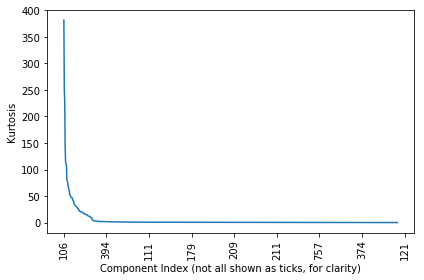

In [48]:
fig, ax = plt.subplots()

ax.plot(range(len(k_sorted)), k_sorted, )
ax.set_xticklabels(k_sorted.index, rotation='vertical')
# ax.set_xticks(range(len(k_sorted)))
# plt.xticks(k_sorted.index)
# ax.xticks(k_sorted.index)
# ax.xaxis.set_major_locator(MaxNLocator(len(k_sorted.index), integer=True))

ax.set_xlabel("Component Index (not all shown as ticks, for clarity)")
ax.set_ylabel("Kurtosis")
fig.tight_layout()
fig.savefig(f'{casename}_kurtosis.png')

In [47]:
# n_components = [2, 3, 4, 5, 7, 10, 13, 15, 20, 25, 30, 35, 40]
reconstruction_error = np.zeros(len(n_components))
for i, this_n in enumerate(n_components):
    pipe_reconstruction = Pipeline([('scaler', StandardScaler()), 
                                       (f'{dim_red_name}', FastICA(random_state=random_state, n_components=this_n, max_iter=max_iter))])
    pipe_reconstruction.fit(X)
    reconstruction_error[i] = get_reconstruction_error(X, pipe_reconstruction)
joblib.dump(np.array((n_components, reconstruction_error)).T, f'{casename}_reconstruction_error.pkl')

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)
C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


['quickdraw_ica_reconstruction_error.pkl']

## Run MLP using results of ICA through Grid Search

In [95]:
pipe = Pipeline([('scaler', StandardScaler()),
                  ('ica', FastICA(random_state=random_state, max_iter=max_iter)),
                  ('mlp', MLPClassifier(max_iter=max_iter, random_state=random_state))])

#                  [0.5, 0.75, 0.9, 0.95, 0.99]
hidden_layer_sizes = [(2, ), (4, ), (6, ), (10, )]
param_grid = {'ica__n_components': n_components,
             'mlp__hidden_layer_sizes': hidden_layer_sizes,
             }
gs = GridSearchCV(pipe, param_grid=param_grid, verbose=10, cv=5, return_train_score=True, 
                  n_jobs=n_jobs)

In [96]:
gs.fit(X, y)
joblib.dump(gs, casename + "_gs.pkl")

Fitting 5 folds for each of 44 candidates, totalling 220 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   36.0s
[Parallel(n_jobs=-1)]: Done  45 tasks      | elapsed:   44.4s
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  69 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  82 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 129 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 165 tasks      | elapsed: 20.4min
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed: 32

['quickdraw_ica_gs.pkl']

In [106]:
gs.best_params_

{'ica__n_components': 34, 'mlp__hidden_layer_sizes': (10,)}

In [101]:
results = pd.DataFrame(gs.cv_results_)
results.to_csv(casename + "_results.csv")

In [20]:
# results = pd.read_csv(f'{casename}_results.csv')

In [21]:
results.loc[:, ["param_mlp__hidden_layer_sizes", "param_ica__n_components", "mean_test_score", "mean_train_score"]]

,param_mlp__hidden_layer_sizes,param_ica__n_components,mean_test_score,mean_train_score
0,"(2,)",1,0.50000,0.500000
1,"(4,)",1,0.50000,0.500000
2,"(6,)",1,0.57725,0.575438
3,"(10,)",1,0.57900,0.578688
4,"(2,)",2,0.50000,0.500000
5,"(4,)",2,0.55100,0.555688
6,"(6,)",2,0.58300,0.578563
7,"(10,)",2,0.57950,0.583375
8,"(2,)",9,0.50000,0.500000
9,"(4,)",9,0.80550,0.803750


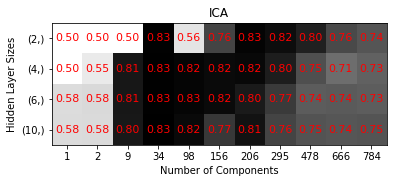

In [24]:
x_variable = "param_ica__n_components"
y_variable = "param_mlp__hidden_layer_sizes"
z_variable = "mean_test_score"

df_to_heatmap(results, x_variable, y_variable, z_variable, fontsize=11, title=f'{dim_red_name.upper()}', xlabel='Number of Components', ylabel='Hidden Layer Sizes', savefig=f'{casename}_gs.png')

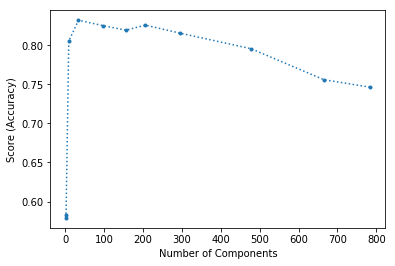

In [23]:
x_variable = "param_ica__n_components"
z_variable = "mean_test_score"
best_scores = get_max_along_df_axis(results, z_variable, x_variable)
fig, ax = plt.subplots()
ax.plot(best_scores[:, 0], best_scores[:, 1], '.:', label='MLP fit on ICA')
ax.set_xlabel("Number of Components")
ax.set_ylabel("Score (Accuracy)")
plt.show()

In [49]:
kurt_pipe = Pipeline([('scaler', StandardScaler()),
                  (f'{dim_red_name}', FastICA(n_components=784, random_state=random_state, max_iter=max_iter))])
kurt_pipe.fit(X, y)
X_transformed = kurt_pipe.transform(X)
df_ICA_components = pd.DataFrame(X_transformed)
k_sorted = df_ICA_components.kurt(axis=0).abs().sort_values(ascending=False)

C:\Users\Scribs\Anaconda3\lib\site-packages\sklearn\decomposition\fastica_.py:121: ConvergenceWarning: FastICA did not converge. Consider increasing tolerance or the maximum number of iterations.
  ConvergenceWarning)


Text(0, 0.5, 'Kurtosis')

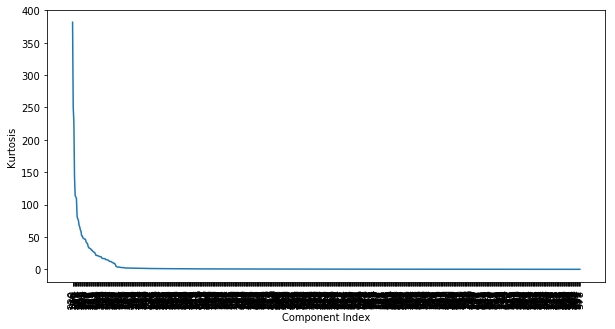

In [50]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(range(len(k_sorted)), k_sorted, )
ax.set_xticklabels(k_sorted.index, rotation='vertical')
ax.set_xticks(range(len(k_sorted)))
# plt.xticks(k_sorted.index)
# ax.xticks(k_sorted.index)
# ax.xaxis.set_major_locator(MaxNLocator(len(k_sorted.index), integer=True))
ax.set_xlabel("Component Index")
ax.set_ylabel("Kurtosis")